In [1]:
#Enter Key here: B2@2024KAUSTUKICv9YZDN

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image
from IPython.display import clear_output
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision
from torchvision import models,transforms
from torchvision.utils import make_grid
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
import imageio as imo
import os
import time
from sklearn.metrics import classification_report
from PIL import Image


In [3]:
# Download the file using gdown
!gdown --id 1X1wDxH1X8RRwwudD9YG2paOqtL3woCsJ -O reshaped_mnist.zip

# Unzip the file
!unzip reshaped_mnist.zip

Streaming output truncated to the last 5000 lines.
 extracting: reshaped_mnist/12074_9.png  
 extracting: reshaped_mnist/35503_9.png  
 extracting: reshaped_mnist/50460_5.png  
 extracting: reshaped_mnist/8127_9.png  
 extracting: reshaped_mnist/9284_2.png  
 extracting: reshaped_mnist/48391_2.png  
 extracting: reshaped_mnist/53674_4.png  
 extracting: reshaped_mnist/20296_7.png  
  inflating: reshaped_mnist/25503_4.png  
 extracting: reshaped_mnist/50301_5.png  
 extracting: reshaped_mnist/50447_1.png  
 extracting: reshaped_mnist/18358_7.png  
 extracting: reshaped_mnist/59876_6.png  
 extracting: reshaped_mnist/48049_5.png  
 extracting: reshaped_mnist/16552_8.png  
 extracting: reshaped_mnist/12648_8.png  
 extracting: reshaped_mnist/31023_8.png  
 extracting: reshaped_mnist/42158_2.png  
 extracting: reshaped_mnist/429_0.png  
 extracting: reshaped_mnist/7680_9.png  
 extracting: reshaped_mnist/14087_3.png  
 extracting: reshaped_mnist/33553_5.png  
  inflating: reshaped_mnist/54

In [4]:
!gdown --id 1uPlA-pbks1XrRyA1hgLPh1rzW7pMK0px -O image_positions.csv


/usr/local/lib/python3.10/dist-packages/gdown/cli.py:138: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1uPlA-pbks1XrRyA1hgLPh1rzW7pMK0px
To: /content/image_positions.csv
100% 1.41M/1.41M [00:00<00:00, 7.63MB/s]


  Filepath  Top_Left_X  Top_Left_Y  Width  Height
0  0_5.png          18           3     28      56
1  1_0.png           4          24     56      28
2  2_4.png           1          21     56      28
3  3_1.png          24           4     28      56
4  4_9.png          17           2     28      56


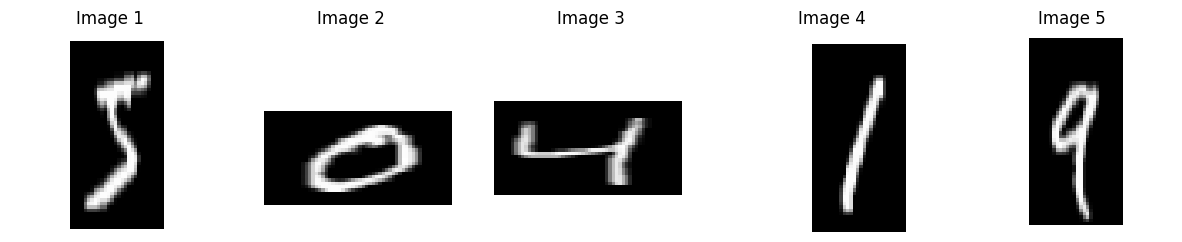

In [5]:
import numpy as np
# Load the CSV file
df = pd.read_csv('image_positions.csv')

# Display the first 5 rows of the dataframe
print(df.head(5))

# Assuming 'Filepath' column contains the relative image paths
image_dir = 'reshaped_mnist/'

# Read and display the first 5 images
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, row in df.head(5).iterrows():
    filepath = os.path.join(image_dir, row['Filepath'])
    image = np.array(Image.open(filepath))
    axes[i].imshow(image)
    axes[i].set_title(f"Image {i+1}")
    axes[i].axis('off')
    if (i == 0):
      showImage = image

plt.show()


# Exercise: Image Preprocessing and CNN Model Development
## Objective:
In this exercise, you are tasked with developing a Convolutional Neural Network (CNN) model to classify images based on a provided dataset. The images are contained within a larger white background, and their actual dimensions vary between two sizes: 28x56 pixels and 56x28 pixels. Your challenge involves multiple steps, including data preprocessing, dataset creation, and CNN model development.

## Dataset Description:
The dataset is defined in a CSV file named image_positions.csv, which includes the following columns:

- Filepath: The filename of the image, with the label after the "_"
- Top_Left_X: The top-left X-coordinate of the image within the larger background.
- Top_Left_Y: The top-left Y-coordinate of the image within the larger background.
- Width: The width of the actual image.
- Height: The height of the actual image.


Sample is shown above

Images are embedded into a larger white
canvas and need to be cropped to remove the white background and standardized in size for model input.

# Tasks:
## Data Preprocessing:

- Read the CSV file and for each image, crop it according to the specified coordinates and dimensions to remove the white background.
- Standardize the size of the images for the CNN model to (28 by 28) by downsampling with a factor of 2 the image along the dimesion with size 56. (you should write your own code for it, you can simply skip every second row/column to achieve this)
- Display a batch of the cropped and downsampled (28 by 28) image.
  
## Dataset Preparation:

- Split your preprocessed images into training and testing datasets. Ensure you have a balanced distribution of classes in both sets.
- Implement data augmentation techniques if necessary to increase the diversity of your training dataset and improve model robustness.

## CNN Model Development:

- Design and implement a CNN model architecture of your choice to classify the images into their respective categories.
- Compile and train your model using the training dataset. Choose an appropriate loss function and optimizer for the classification task.
- Evaluate your model's performance on the testing dataset. Provide insights into its accuracy and potential areas for improvement.

In [6]:
num_images = len(df)
num_images

60000

In [7]:
class ImageExtDataset(Dataset):
  def __init__(self, old_df, images_directory, transform = None):
    self.old_df = old_df
    self.images_directory =images_directory
    self.transform = transform
    self.df = self.extract_image_and_create_list()

  def extract_image_and_create_list(self):
    # image = self.old_df['Filepath']
    image_path_list = []
    label_list = []
    top_left_X_list = []
    top_left_Y_list = []
    height_list = []
    width_list = []
    for i in range(len(self.old_df)):
      row = self.old_df.iloc[i]
      image_path_list.append(f'{self.images_directory}/{row["Filepath"]}')
      label_list.append(int(row['Filepath'][-5])) # '0_5.png' As you can see, the label is at index -5
      top_left_X_list.append(row['Top_Left_X'])
      top_left_Y_list.append(row['Top_Left_Y'])
      height_list.append(row['Height'])
      width_list.append(row['Width'])

    image_df = pd.DataFrame({"image_path":image_path_list, "image_label":label_list, 'Top_Left_X':top_left_X_list, 'Top_Left_Y':top_left_Y_list, 'Height':height_list, 'Width': width_list})
    return image_df

  def __len__(self):
    return len(self.df)

  def __getitem__(self, index):
    df_row = self.df.iloc[index]

    image_path = df_row["image_path"]
    label = df_row["image_label"]
    Top_Left_X = df_row["Top_Left_X"]
    Top_Left_Y = df_row["Top_Left_Y"]
    Height = df_row["Height"]
    Width = df_row["Width"]

    image = Image.open(image_path)
    image = torchvision.transforms.functional.crop(image, top= Top_Left_Y, left= Top_Left_X, height= Height, width= Width)
    if self.transform:
      image = self.transform(image)

    return image, label

transformations = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((28, 28)), # I did not have enough time to do the resize manually unfortunatly
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), # data augmentation
])
dataset = ImageExtDataset(df, 'reshaped_mnist', transform = transformations)
dataset[0]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


(tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044, -1.8044,

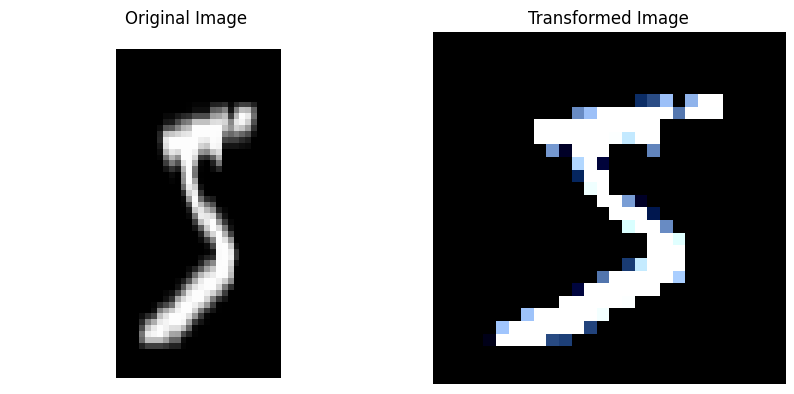

In [8]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(showImage)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(dataset[0][0].permute(1,2,0))
plt.title('Transformed Image')
plt.axis('off')

plt.show()

In [9]:
from torch.utils.data import DataLoader, random_split

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

In [10]:
image = df.iloc[0]['Filepath']
image

'0_5.png'

In [11]:
dataset[0][0].size()

torch.Size([3, 28, 28])

In [12]:
class CNN(nn. Module):

  def __init__ (self, in_channels = 3, out_classes = 10):

    super(CNN, self).__init__()

    self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=5, stride = 1, padding = 2)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride = 1, padding = 1)
    self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride = 1, padding = 1)

    self.Bn1 = nn.BatchNorm2d(32)    #Make convergence faster
    self.Bn2 = nn.BatchNorm2d(64)   #Make convergence faster
    self.Bn3 = nn.BatchNorm2d(128)   #Make convergence faster

    self.relu = nn.ReLU()
    self.pool = nn.MaxPool2d(2,2)
    self.fc1 = nn.Linear(128*3*3, 256)
    self.fc2 = nn.Linear(256, out_classes)
    self.dropout = nn.Dropout(0.2)

    # self.softmax = nn.Softmax(dim=1)

  def forward(self, x):

    x = self.conv1(x) # 32*28*28
    x = self.Bn1(x)
    x = self.relu(x)
    x = self.pool(x) # 32*14*14
    x = self.dropout(x)

    x = self.conv2(x) # 64*14*14
    x = self.Bn2(x)
    x = self.relu(x)
    x = self.pool(x) # 64*7*7
    x = self.dropout(x)

    x = self.conv3(x) # 128*7*7
    x = self.Bn3(x)
    x = self.relu(x)
    x = self.pool(x) # 128*3*3
    x = self.dropout(x)

    x = nn.Flatten()(x) # -1, 128*3*3

    x = self.fc1(x)
    x = self.relu(x)
    x = self.fc2(x)

    return x

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'  # checks if machine supports cuda and if it does, we use that, otherwise cpu
print(f'Using device {device}')

num_epochs = 8
train_losses = []
test_losses = []

model = CNN()

lr = 0.01 # Learning rate for the SGD optimizer.
momentum = 0.9
weight_decay=5e-4
optimizer = optim.SGD(model.parameters(), lr = lr, momentum = momentum, weight_decay = weight_decay)
learning_rate_scheduler = ExponentialLR(optimizer, 0.9, verbose = False)

criterion = nn.CrossEntropyLoss()  # multi-class

model.to(device)  # we need to send all input tensors as well as our model to this device. by default they are on cpu

start_time = time.time()
for epoch_no in range(num_epochs):
  epoch_start_time = time.time()
  model.train()  # convert to train model. This turns out train-specific layers in the model (if you dont know about them, an example of them is dropout. more on this later)

  epoch_weighted_loss = 0

  for X, y in train_loader:

    X = X.to(device)
    y = y.to(device)

    probs = model(X)
    optimizer.zero_grad()  # need to clear out gradients from previous batch

    loss = criterion(probs, y)

    loss.backward()  # calculate new gradients
    optimizer.step()  # update weights

    epoch_weighted_loss += (len(y)*loss.item())

  # validation time

  model.eval()  # take model to evaluation mode. turn off train-only layers
  correctly_labelled = 0

  with torch.no_grad():  # this makes our model to NOT track gradients

    test_epoch_weighted_loss = 0

    for X, y in test_loader:

      X = X.to(device)
      y = y.to(device)

      probs = model(X)

      loss = criterion(probs, y)
      test_epoch_weighted_loss += (len(y)*loss.item())

      pred = probs.argmax(dim=1)  # convert probailities to labels by picking the label (index) with the highest prob

      correctly_labelled += (pred == y).sum().item()  # item converts tensor to float/int/list

  test_epoch_loss = test_epoch_weighted_loss/len(test_loader.dataset)
  test_losses.append(test_epoch_loss)

  epoch_loss = epoch_weighted_loss/len(train_loader.dataset)
  train_losses.append(epoch_loss)    # add loss for tracking. we'll visualize the loss trajectory later
  learning_rate_scheduler.step() # update learning rate

  epoch_total_time = time.time() - epoch_start_time
  epoch_mins = int(epoch_total_time // 60)
  epoch_secs = int(epoch_total_time % 60)

  print(f'Epoch: {(epoch_no + 1):2d}, train_loss = {epoch_loss:.2f}, val_loss = {test_epoch_loss:.2f}. labelled {correctly_labelled}/{len(test_loader.dataset)} correctly ({(correctly_labelled/len(test_loader.dataset)*100):.2f}% accuracy). Time: {epoch_mins} minutes, {epoch_secs} seconds')

total_time = time.time() - start_time
mins = int(total_time // 60)
secs = int(total_time % 60)

print(f'Total training time: {mins} minutes, {secs} seconds')

Using device cuda
Epoch:  1, train_loss = 0.16, val_loss = 0.05. labelled 11833/12000 correctly (98.61% accuracy). Time: 0 minutes, 59 seconds
Epoch:  2, train_loss = 0.06, val_loss = 0.06. labelled 11800/12000 correctly (98.33% accuracy). Time: 0 minutes, 58 seconds
Epoch:  3, train_loss = 0.04, val_loss = 0.03. labelled 11887/12000 correctly (99.06% accuracy). Time: 0 minutes, 57 seconds
Epoch:  4, train_loss = 0.03, val_loss = 0.03. labelled 11887/12000 correctly (99.06% accuracy). Time: 0 minutes, 57 seconds
Epoch:  5, train_loss = 0.03, val_loss = 0.03. labelled 11914/12000 correctly (99.28% accuracy). Time: 0 minutes, 57 seconds
Epoch:  6, train_loss = 0.03, val_loss = 0.02. labelled 11918/12000 correctly (99.32% accuracy). Time: 0 minutes, 57 seconds
Epoch:  7, train_loss = 0.02, val_loss = 0.02. labelled 11911/12000 correctly (99.26% accuracy). Time: 0 minutes, 58 seconds
Epoch:  8, train_loss = 0.02, val_loss = 0.02. labelled 11931/12000 correctly (99.42% accuracy). Time: 0 mi

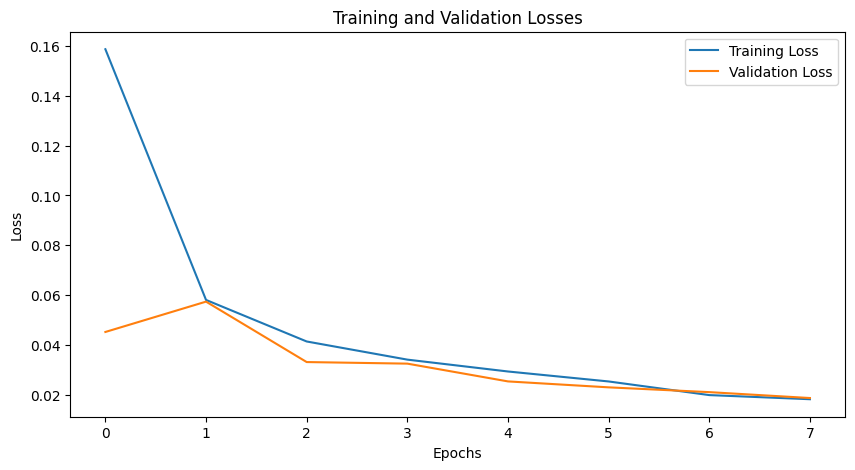

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [15]:
def evaluate_model(model, test_loader): # it does the validation and it outputs the predicted values and target.
    model.eval()
    preds = []
    targets = []
    with torch.no_grad():
        for X, y in test_loader:
            X = X.to(device)
            probs = model(X)
            predicted_classes = torch.argmax(probs, dim=1)
            preds.extend(predicted_classes.cpu().tolist())
            targets.extend(y.cpu().tolist())
    return preds, targets

def calculate_accuracy(preds, targets): # it calculates the accuracywhen given predicted values and target.
    correct = sum(p == t for p, t in zip(preds, targets))
    total = len(targets)
    accuracy = correct / total * 100
    return correct, total, accuracy


In [17]:
preds, targets = evaluate_model(model, test_loader)
correct, total, accuracy = calculate_accuracy(preds, targets)
print('Overall Accuracy:')
print(f'labelled {correct}/{len(test_loader.dataset)} correctly ({(correct/len(test_loader.dataset)*100):.2f}% accuracy).')


Overall Accuracy:
labelled 11931/12000 correctly (99.42% accuracy).


# Provide insights into its accuracy and potential areas for improvement

# areas for improvement
we could improve by adding more augmentations, like rotate or so on the whole data set and then concatenate it with original data set by the following class, but unfortunally I didnt have time to add it to the code.
Also, doing ensembling by adding more models could help a lot.

In [19]:
class CustomDataset:
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        df_row = self.dataframe[idx]

        image_path = df_row[0]
        label = df_row[1]
        print(image_path)
        image = Image.open(image_path)
        if self.transform:
            image = self.transform(image)
        return image, label

#insights into its accuracy
Ensembling can defenetely increase the accuracy
And using pretrained model like resnet18 would give us more accuracy